# Sampling from a bivariate normal mixture via Metropolis-Hastings

In [1]:
## Import packages

import numpy as np

import scipy.stats as stats

import torch

from torch.utils.data import DataLoader
from torch.distributions import MultivariateNormal

from eeyore.models.density import Density
from eeyore.kernels import NormalKernel
from eeyore.mcmc import MetropolisHastings

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Set up empty data loader

dataloader = DataLoader([[[], []]])

# for data, label in dataloader:
#     print("Iteration", data, label)

In [3]:
## Set up unnormalized target density

def target(theta, w, components):
    return w[0] * torch.exp(components[0].log_prob(theta)) + w[1] * torch.exp(components[1].log_prob(theta))

weights = [0.5, 0.5]
means = [-2 * torch.ones(2), 2 * torch.ones(2)]
covs = [1 * torch.eye(2), 1 * torch.eye(2)]
     
def log_target(theta, dataloader):
    return torch.log(target(
        theta,
        weights,
        [
            MultivariateNormal(means[0], covariance_matrix=covs[0]),
            MultivariateNormal(means[1], covariance_matrix=covs[1])
        ]))

density = Density(log_target, dtype=torch.float32)

In [4]:
## Setup Metropolis-Hastings sampler

theta0 = torch.tensor([0., 0.], dtype=torch.float32)
density.set_params(theta0)
sampler = MetropolisHastings(density, theta0, dataloader, symmetric=True)

In [5]:
## Run Metropolis-Hastings sampler

sampler.run(num_iterations=11000, num_burnin=1000)

In [6]:
## Compute acceptance rate

sampler.chain.acceptance_rate()

0.5644000172615051

In [7]:
## Compute Monte Carlo mean

sampler.chain.mean()

tensor([ 0.0406, -0.0084])

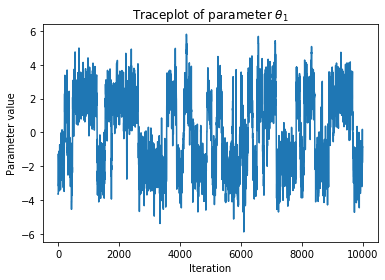

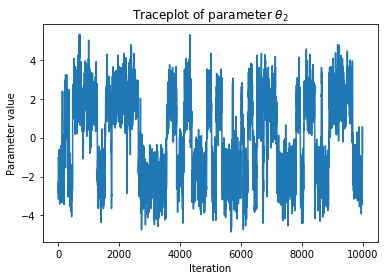

In [8]:
## Plot traces of simulated Markov chain

for i in range(density.num_params()):
    chain = sampler.chain.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter $\theta_{}$'.format(i+1))

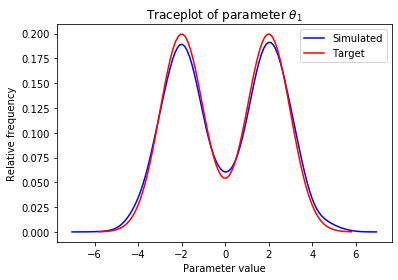

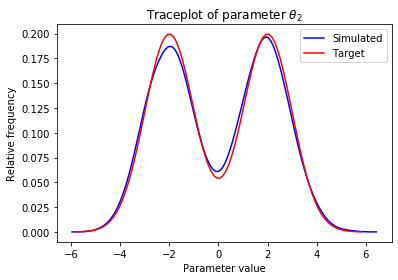

In [9]:
## Plot histograms of marginals of simulated Markov chain

for i in range(density.num_params()):
    range_min = min([means[j][i].item() for j in range(2)])
    range_max = max([means[j][i].item() for j in range(2)])
    range_len = range_max - range_min
    hist_range = np.linspace(range_min - 0.95 * abs(range_len), range_max + 0.95 * abs(range_len), 100)
    plt.figure()
    plot = sns.distplot(sampler.chain.get_theta(i), hist=False, color='blue', label='Simulated')
    plot.set_xlabel('Parameter value')
    plot.set_ylabel('Relative frequency')
    plot.set_title(r'Traceplot of parameter $\theta_{}$'.format(i+1))
    sns.lineplot(
        hist_range,
        weights[0] * stats.norm.pdf(hist_range, means[0][i].item(), covs[0][i, i]) +
        weights[1] * stats.norm.pdf(hist_range, means[1][i].item(), covs[1][i, i]),
        color='red',
        label='Target'
    )
    plot.legend()

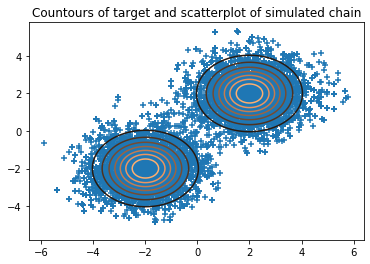

In [10]:
## Plot scatter of simulated Markov chain

xmin = min([means[j][0].item() for j in range(2)])
xmax = max([means[j][0].item() for j in range(2)])
xlen = xmax - xmin

ymin = min([means[j][1].item() for j in range(2)])
ymax = max([means[j][1].item() for j in range(2)])
ylen = ymax - ymin

x_contour_range, y_contour_range = np.mgrid[
    (xmin - 0.95 * abs(xlen)):(xmax + 0.95 * abs(xlen)):.01,
    (ymin - 0.95 * abs(ylen)):(ymax + 0.95 * abs(ylen)):.01
]

contour_grid = np.empty(x_contour_range.shape+(2,))
contour_grid[:, :, 0] = x_contour_range
contour_grid[:, :, 1] = y_contour_range

# target = stats.multivariate_normal([0., 0.], [[1., 0.], [0., 1.]])

def target_scipy(theta):
    return (
        weights[0] * stats.multivariate_normal(means[0].cpu().numpy(), covs[0].cpu().numpy()).pdf(theta) +
        weights[1] * stats.multivariate_normal(means[1].cpu().numpy(), covs[1].cpu().numpy()).pdf(theta)
    )

plt.scatter(x=sampler.chain.get_theta(0), y=sampler.chain.get_theta(1), marker='+')
plt.contour(x_contour_range, y_contour_range, target_scipy(contour_grid), cmap='copper')
plt.title('Countours of target and scatterplot of simulated chain');

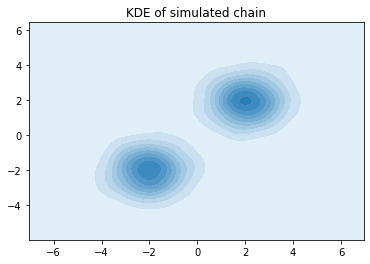

In [11]:
## Plot KDE of target of simulated Markov chain

plot = sns.kdeplot(sampler.chain.get_theta(0), sampler.chain.get_theta(1), shade=True)
plot.set_title('KDE of simulated chain');

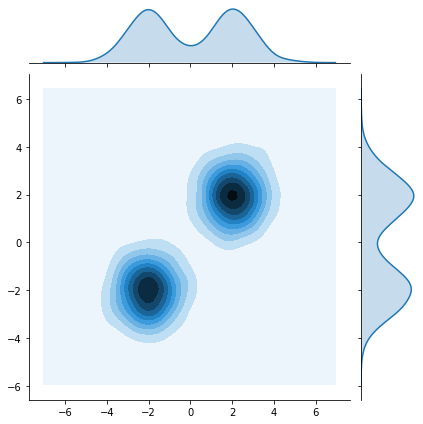

In [12]:
## Plot KDEs of target and of marginals of simulated Markov chain

plot = sns.jointplot(sampler.chain.get_theta(0), sampler.chain.get_theta(1), kind="kde")

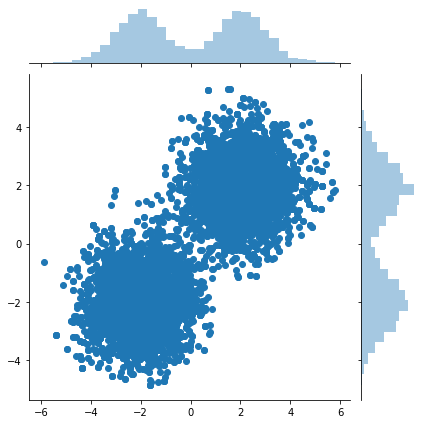

In [13]:
## Plot scatter of target and histograms of marginals of simulated Markov chain

sns.jointplot(sampler.chain.get_theta(0), sampler.chain.get_theta(1), kind="scatter");